# Installing Gymansium

<b>LEARNING ABOUT HMM AND Q-LEARNING</b>

I think the idea was to:
(1) Derive the Q-learning from an HMM for normally distributed rewards
(2) Then see how this derivation works for binary outcomes -> Beta distributions

Never finished

---
# Setup

In [1]:
# @title imports
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from popy.simulation_tools import *

from simulation_helpers import simulate_agent

In [2]:
# @title Helper functions
def grid_search(param_grid, agent):
    results = []
    
    # Get the keys and values from the param_grid
    keys, values = zip(*param_grid.items())
    
    # Generate all combinations of parameters
    param_combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
    
    for param_combination in param_combinations:
        # Set the parameters of the agent
        for key, value in param_combination.items():
            setattr(agent, key, value)

        # Simulate the agent
        behavior = simulate_agent(agent)

        # Calculate the mean reward
        result = {key: value for key, value in param_combination.items()}
        result["prop_best_arm"] = (behavior["action"].values == behavior["best_arm"].values).mean()
        results.append(result)

    return pd.DataFrame(results)

def add_block_info(behav):
    curr_best_target = -1
    trial_in_block_counter = -1
    block_counter = -1
    trial_in_block_vector = []
    block_id_vector = []
    for i, row in behav.iterrows():
        if row['best_arm'] != curr_best_target:
            trial_in_block_counter = 0
            block_counter += 1
            curr_best_target = row['best_arm']
        else:
            trial_in_block_counter += 1

        trial_in_block_vector.append(trial_in_block_counter)
        block_id_vector.append(block_counter)
    
    behav['block_id'] = block_id_vector
    behav["trial_in_block"] = trial_in_block_vector

    return behav

def add_history(behav):
    history_r_m1 = []
    history_r_m2 = []
    history_r_m3 = []
    for block_id, behav_block in behav.groupby('block_id'):
        history_r_m1.append(behav_block['reward'].shift(1))
        history_r_m2.append(behav_block['reward'].shift(2))
        history_r_m3.append(behav_block['reward'].shift(3))

    behav['r_m1'] = np.concat(history_r_m1)
    behav['r_m2'] = np.concat(history_r_m2)
    behav['r_m3'] = np.concat(history_r_m3)
    
    return behav

def add_switch_info(behav):
    switch = []
    for block_id, behav_block in behav.groupby('block_id'):
        switch.append(behav_block['action'] != behav_block['action'].shift(1))

    switch =  np.concat(switch)
    behav['switch'] = np.concat([np.array([np.nan]), switch[1:]])

    return behav

def add_trial_since_switch(behav):
    trial_since_switch = -1
    trial_since_switch_vector = []
    for i, row in behav.iterrows():
        trial_since_switch_vector.append(trial_since_switch)
        if row['switch'] == 1:
            trial_since_switch = 0
        else:
            trial_since_switch += 1

    trial_since_switch_vector[0]  = np.nan
    behav['trials_since_witch'] = trial_since_switch_vector
    return behav



In [3]:
# @title plotting
def _plot_behav(behavior, ax=None):
    # plot the behavior
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    for i, row in behavior.iterrows():
        ax.scatter(row.name, row["action"],
                    label="Action" if i == 0 else "", color="black", alpha=0.5, marker="o" if row["reward"] == 1 else "x")       
            
    ax.set_xlabel("Time step (trial)")
    ax.set_ylabel("action")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_yticks([0, 1, 2])
    ax.grid(axis="y")
    ax.spines["top"].set_visible(False)
    
    if ax is None:
        plt.show()
    else:
        return ax
    
def plot_bayesian_bandit(behav):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    prop_best_arm = (behav["best_arm"].values == behav["action"].values).mean()
    mean_rr = behav["reward"].mean()

    fig.suptitle(f"Bayes agent, \np(best arm): {prop_best_arm:.2f}, rew.rate: {mean_rr:.2f}")
    behav_to_plot = behav.tail(100)
    ax = _plot_behav(behav_to_plot, ax)
    ax.plot(behav_to_plot["best_arm"], label="Best arm", color="red", linestyle="--")

    q_values = np.stack(behav_to_plot["posterior"].values)
    ax_ = ax.twinx()
    ax_.plot(behav_to_plot.index+1, q_values[:, 0], label="Posterior state 0", color="blue", linestyle="-", alpha=0.5)  
    ax_.plot(behav_to_plot.index+1, q_values[:, 1], label="Posterior state 1", color="green", linestyle="-", alpha=0.5)
    ax_.plot(behav_to_plot.index+1, q_values[:, 2], label="Posterior state 2", color="orange", linestyle="-", alpha=0.5)
    ax_.set_ylabel("Posterior")
    ax_.legend(bbox_to_anchor=(1.05, 0.75), loc='center left')
    ax_.set_ylim(-.1, 1.1)

    plt.show()
    
def plot_q_agent(behav):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    prop_best_arm = (behav["best_arm"].values == behav["action"].values).mean()
    mean_rr = behav["reward"].mean()

    fig.suptitle(f"Q-learning agent, \np(best arm): {prop_best_arm:.2f}, rew.rate: {mean_rr:.2f}")
    behav_to_plot = behav.tail(100)
    ax = _plot_behav(behav_to_plot, ax)
    ax.plot(behav_to_plot["best_arm"], label="Best arm", color="red", linestyle="--")

    q_values = np.stack(behav_to_plot["q_values"].values)
    ax_ = ax.twinx()
    ax_.plot(behav_to_plot.index+1, q_values[:, 0], label="Q-value arm 0", color="blue", linestyle="-", alpha=0.5)  
    ax_.plot(behav_to_plot.index+1, q_values[:, 1], label="Q-value arm 1", color="green", linestyle="-", alpha=0.5)
    ax_.plot(behav_to_plot.index+1, q_values[:, 2], label="Q-value arm 2", color="orange", linestyle="-", alpha=0.5)
    ax_.set_ylabel("Q-value")
    ax_.legend(bbox_to_anchor=(1.05, 0.75), loc='center left')
    ax_.set_ylim(-1, 1)

    plt.show()

def plot_strategy_value_agent(behav):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    prop_best_arm = (behav["best_arm"].values == behav["action"].values).mean()
    mean_rr = behav["reward"].mean()

    fig.suptitle(f"Shift-value agent, \np(best arm): {prop_best_arm:.2f}, rew.rate: {mean_rr:.2f}")
    behav_to_plot = behav.tail(100)
    ax = _plot_behav(behav_to_plot, ax)
    ax.plot(behav_to_plot["best_arm"], label="Best arm", color="red", linestyle="--")

    expectations = np.stack(behav_to_plot["Q"].values)
    ax_ = ax.twinx()
    ax_.plot(behav_to_plot.index+1, expectations, label="Q", color="blue", linestyle="-", alpha=0.5)  
    ax_.plot(behav_to_plot.index+1, np.ones_like(expectations) * behav_to_plot["V0"].values[0], label="V0", color="green", linestyle="--", alpha=0.5)
    ax_.set_ylabel("Q")
    ax_.legend(bbox_to_anchor=(1.05, 0.75), loc='center left')
    ax_.set_ylim(-1, 1)

    plt.show()

def plot_wsls_agent(behav):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    prop_best_arm = (behav["best_arm"].values == behav["action"].values).mean()
    mean_rr = behav["reward"].mean()

    fig.suptitle(f"WSLS agent, \np(best arm): {prop_best_arm:.2f}, rew.rate: {mean_rr:.2f}")
    behav_to_plot = behav.tail(100)
    ax = _plot_behav(behav_to_plot, ax)
    ax.plot(behav_to_plot["best_arm"], label="Best arm", color="red", linestyle="--")

    plt.show()

def plot_parameter_heatmap(results):
    assert len(results.columns) == 3, "The results should have exactly 3 columns"

    pivot_table = results.pivot(index=results.columns[0], columns=results.columns[1], values='prop_best_arm')
    # round prop_best_arm to 2 decimal places
    pivot_table = pivot_table.round(2)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt="g", cmap="viridis", cbar_kws={'label': 'Proportion of best arm choices'})

    # xticks and yticks rounded to 2 decimal places
    plt.xticks(np.arange(len(results[results.columns[1]].unique())) + 0.5, np.round(results[results.columns[1]].unique(), 2))
    plt.yticks(np.arange(len(results[results.columns[0]].unique())) + 0.5, np.round(results[results.columns[0]].unique(), 2))

    plt.title('Heatmap of the proportion of best arm choices')
    plt.xlabel(results.columns[1])
    plt.ylabel(results.columns[0])
    plt.show()

def plot_summary_stats(behav):
    behav = add_block_info(behav)

    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    # proba best selection
    first_20 = []
    last_20 = []
    # create matrices of first/last 20 trials of each block
    for block_id, behav_block in behav.groupby('block_id'):
        if len(behav_block) < 35 or len(behav_block) > 45: continue 
        is_best_selection = behav_block['action'] == behav_block['best_arm']
        first_20.append(is_best_selection[:20])
        last_20.append(is_best_selection[-20:])
    first_20 = np.array(first_20)
    last_20 = np.array(last_20)
    # plot mean +- 2 std
    axs[0].plot(np.arange(1, 21), first_20.mean(axis=0))
    axs[0].plot(np.arange(22, 42), last_20.mean(axis=0))

    axs[0].set_xlabel('trials in block')
    axs[0].set_ylabel('p(best arm)')

    axs[0].spines["right"].set_visible(False)
    axs[0].spines["top"].set_visible(False)

    axs[0].axvline(21, linestyle='--', color='black', alpha=.7)
    axs[0].grid()
    
    # proba shift
    first_20 = []
    last_20 = []
    # create matrices of first/last 20 trials of each block
    for block_id, behav_block in behav.groupby('block_id'):
        if len(behav_block) < 35 or len(behav_block) > 45: continue 
        is_shift = behav_block['action'] != behav_block['action'].shift(1)
        first_20.append(is_shift[1:20])
        last_20.append(is_shift[-20:])
    first_20 = np.array(first_20)
    last_20 = np.array(last_20)
    # plot mean +- 2 std
    axs[1].plot(np.arange(2, 21), first_20.mean(axis=0))
    axs[1].plot(np.arange(22, 42), last_20.mean(axis=0))

    axs[1].set_xlabel('trials in block')
    axs[1].set_ylabel('p(shift)')

    axs[1].spines["right"].set_visible(False)
    axs[1].spines["top"].set_visible(False)

    axs[1].axvline(21, linestyle='--', color='black', alpha=.7)
    axs[1].grid()    



    plt.tight_layout()
    plt.show()

def plot_hist_thingy(behav):
    behav = add_history(behav)
    behav = add_switch_info(behav)
    behav = add_trial_since_switch(behav)
    behav = behav.dropna()

    labels = [ f"+ + +", f"o + +" , f"+ o +", f"o o +", f"+ + o", f"o + o", f"+ o o", f"o o o"]

    fig, ax = plt.subplots(1, 1, figsize=(4, 3))

    all_trials_vector = []
    explore_trials_vector = []
    exploit_trials_vector = []
    for i, ((r_m1, r_m2, r_m3), behav_temp) in enumerate(behav.groupby(['r_m1', 'r_m2', 'r_m3'])):
        all_trials_vector.append(behav_temp['switch'].mean())
        explore_trials_vector.append(behav_temp.loc[behav_temp['trials_since_witch'] < 6]['switch'].mean())
        exploit_trials_vector.append(behav_temp.loc[behav_temp['trials_since_witch'] >= 6]['switch'].mean())

    ax.plot(all_trials_vector, c='grey', label='all_trials', marker='o')
    ax.plot(explore_trials_vector, c='tab:red', label='explore', marker='o')
    ax.plot(exploit_trials_vector, c='tab:green', label='exploit', marker='o')

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45)

    ax.set_xlabel('history')
    ax.set_ylabel('p(switch)')

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.legend()

---
# Section 1: Normal family

In [4]:
# Create the environment
env = gym.make("zsombi/classical-bandit-task-v0",
            n_arms=3,
            family="bernoulli",  # bernoulli, normal
            max_episode_steps=10_000)

## Section 1.1: Q_learning

In [5]:
# initialize the Q-learner agent
agent_qlearn = QLearner(
    env=env,
    alpha=.4,
    beta=5,  # rate of exploration (i.e. random actions)
)

In [6]:
# simulate the agent
behavior_qlearn = simulate_agent(agent_qlearn, behavioral_variables=["q_values"])

behavior_qlearn

,action,reward,block_id,trial_in_block_id,reward_probas,q_values
0,0,0,0,0,"[0.3333333333333333, 0.3333333333333333, 0.333...","[0.2, 0.33333334, 0.33333334]"
1,0,0,0,1,"[0.3333333333333333, 0.3333333333333333, 0.333...","[0.120000005, 0.33333334, 0.33333334]"
2,2,1,0,2,"[0.3333333333333333, 0.3333333333333333, 0.333...","[0.120000005, 0.33333334, 0.6]"
3,2,1,0,3,"[0.3333333333333333, 0.3333333333333333, 0.333...","[0.120000005, 0.33333334, 0.76]"
4,2,0,0,4,"[0.3333333333333333, 0.3333333333333333, 0.333...","[0.120000005, 0.33333334, 0.456]"
...,...,...,...,...,...,...
9995,0,1,249,35,"[0.3267759422684858, 0.005279493645222917, 0.6...","[0.52495146, 0.0004234101, 0.52802444]"
9996,2,1,249,36,"[0.3267759422684858, 0.005279493645222917, 0.6...","[0.52495146, 0.0004234101, 0.71681464]"
9997,0,1,249,37,"[0.3267759422684858, 0.005279493645222917, 0.6...","[0.7149709, 0.0004234101, 0.71681464]"
9998,0,1,249,38,"[0.3267759422684858, 0.005279493645222917, 0.6...","[0.82898253, 0.0004234101, 0.71681464]"


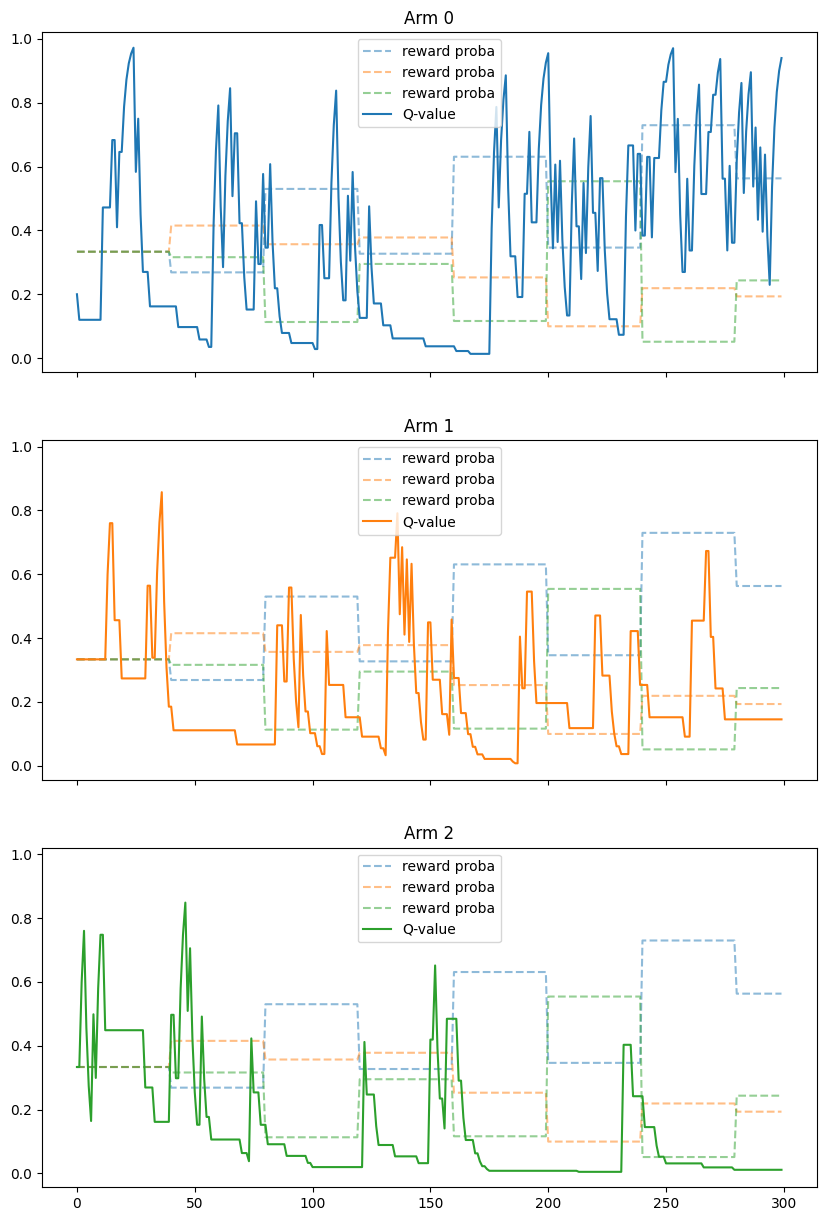

In [7]:
import matplotlib.cm as cm

behav_sample = behavior_qlearn.head(300)

fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True, sharey=True)
for i, ax in enumerate(axs):
    ax.plot(np.stack(behav_sample['reward_probas'].values), label='reward proba', alpha=.5, linestyle='--')
    #ax.plot(np.stack(behav_sample['reward_probas'].values)[:, ~i], color='grey', label='reward proba')
    ax.plot(np.stack(behav_sample['q_values'].values)[:, i], label='Q-value', color=cm.tab10(i))

    ax.set_title(f'Arm {i}')
    ax.legend()
    

## Section 1.1: Bayes

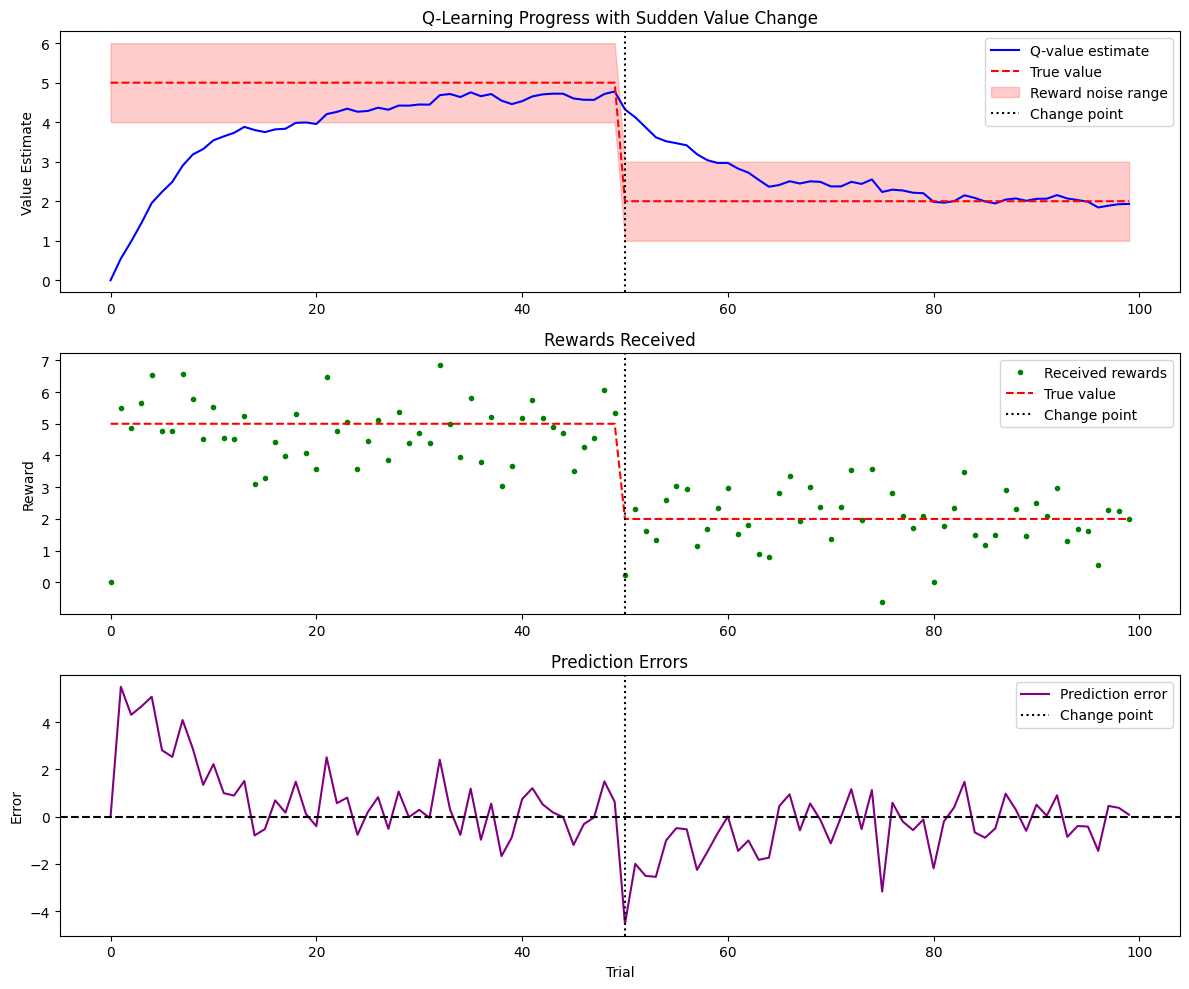

Final Q-value estimate: 1.93 (True value: 2)

Average absolute error before change: 1.150
Average absolute error after change: 0.521


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_trials = 100
initial_value = 5
changed_value = 2  # New reward value after change
noise_std = 1
learning_rate = 0.1
change_point = n_trials // 2  # Change happens halfway through

# Initialize arrays to store data
q_values = np.zeros(n_trials)
rewards = np.zeros(n_trials)
prediction_errors = np.zeros(n_trials)
true_values = np.array([initial_value] * change_point + [changed_value] * (n_trials - change_point))

# Initial Q-value estimate
q_values[0] = 0

# Run simulation
for t in range(1, n_trials):
    # Get true value for current trial
    current_true_value = true_values[t]
    
    # Get noisy reward
    reward = np.random.normal(current_true_value, noise_std)
    rewards[t] = reward
    
    # Calculate prediction error
    prediction_error = reward - q_values[t-1]
    prediction_errors[t] = prediction_error
    
    # Update Q-value
    q_values[t] = q_values[t-1] + learning_rate * prediction_error

# Create figure with subplots
plt.figure(figsize=(12, 10))

# Plot 1: Q-value learning curve
plt.subplot(3, 1, 1)
plt.plot(q_values, 'b-', label='Q-value estimate')
plt.plot(true_values, 'r--', label='True value')
plt.fill_between(range(n_trials), 
                 true_values - noise_std, 
                 true_values + noise_std, 
                 color='r', alpha=0.2, 
                 label='Reward noise range')
plt.axvline(x=change_point, color='k', linestyle=':', label='Change point')
plt.title('Q-Learning Progress with Sudden Value Change')
plt.ylabel('Value Estimate')
plt.legend()

# Plot 2: Rewards over time
plt.subplot(3, 1, 2)
plt.plot(rewards, 'g.', label='Received rewards')
plt.plot(true_values, 'r--', label='True value')
plt.axvline(x=change_point, color='k', linestyle=':', label='Change point')
plt.title('Rewards Received')
plt.ylabel('Reward')
plt.legend()

# Plot 3: Prediction errors over time
plt.subplot(3, 1, 3)
plt.plot(prediction_errors, 'purple', label='Prediction error')
plt.axhline(y=0, color='k', linestyle='--')
plt.axvline(x=change_point, color='k', linestyle=':', label='Change point')
plt.title('Prediction Errors')
plt.xlabel('Trial')
plt.ylabel('Error')
plt.legend()

plt.tight_layout()
plt.show()

# Print final learned value
print(f"Final Q-value estimate: {q_values[-1]:.2f} (True value: {changed_value})")

# Calculate average error before and after change
pre_change_error = np.mean(np.abs(q_values[:change_point] - initial_value))
post_change_error = np.mean(np.abs(q_values[change_point:] - changed_value))
print(f"\nAverage absolute error before change: {pre_change_error:.3f}")
print(f"Average absolute error after change: {post_change_error:.3f}")

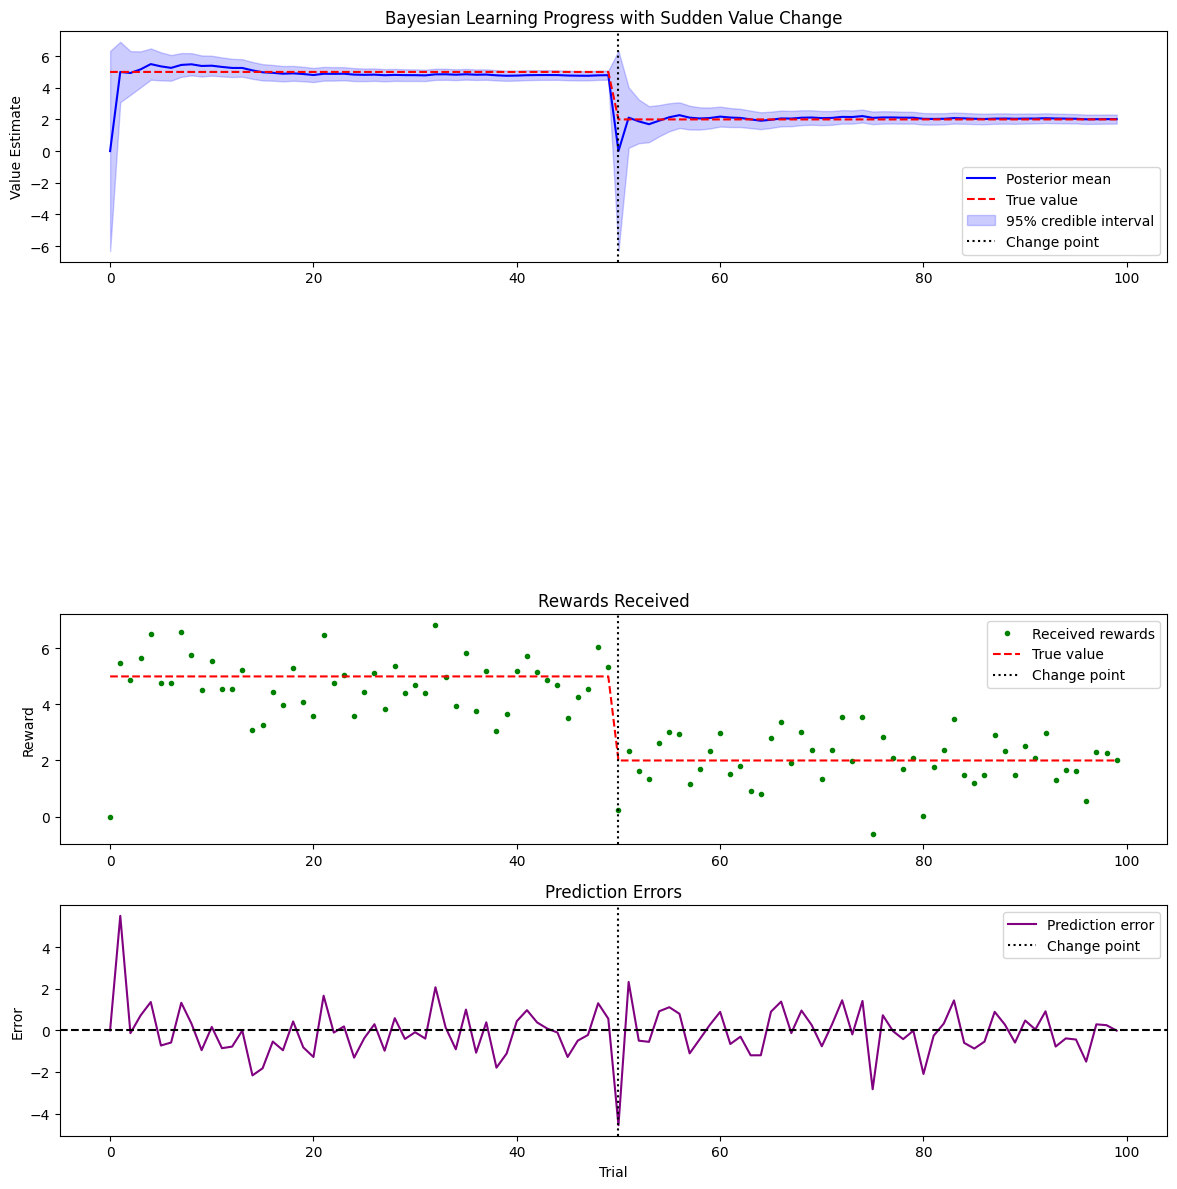

Final posterior mean estimate: 2.02 (True value: 2)
Final posterior variance: 0.020

Average absolute error before change: 0.300
Average absolute error after change: 0.125


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_trials = 100
initial_value = 5
changed_value = 2  # New reward value after change
noise_std = 1
change_point = n_trials // 2  # Change happens halfway through

# Bayesian learner parameters
prior_mean = 0  # Prior belief about mean
prior_var = 10  # Prior uncertainty (relatively uninformative)
noise_var = noise_std ** 2  # Known observation noise
change_detection_threshold = 3  # Number of std devs for change detection

# Initialize arrays to store data
posterior_means = np.zeros(n_trials)
posterior_vars = np.zeros(n_trials)
rewards = np.zeros(n_trials)
prediction_errors = np.zeros(n_trials)
true_values = np.array([initial_value] * change_point + [changed_value] * (n_trials - change_point))

# Initial beliefs
posterior_means[0] = prior_mean
posterior_vars[0] = prior_var

def update_beliefs(prior_mean, prior_var, observation):
    """Perform Bayesian update using Kalman filter equations"""
    # Kalman gain
    k = prior_var / (prior_var + noise_var)
    
    # Update mean
    posterior_mean = prior_mean + k * (observation - prior_mean)
    
    # Update variance
    posterior_var = (1 - k) * prior_var
    
    return posterior_mean, posterior_var

def detect_change(prediction_error, posterior_std):
    """Simple change detection based on prediction errors"""
    return abs(prediction_error) > change_detection_threshold * posterior_std

# Run simulation
for t in range(1, n_trials):
    # Get true value for current trial
    current_true_value = true_values[t]
    
    # Get noisy reward
    reward = np.random.normal(current_true_value, noise_std)
    rewards[t] = reward
    
    # Calculate prediction error
    prediction_error = reward - posterior_means[t-1]
    prediction_errors[t] = prediction_error
    
    # Check for change point
    if detect_change(prediction_error, np.sqrt(posterior_vars[t-1] + noise_var)):
        # Reset beliefs if change detected
        posterior_means[t], posterior_vars[t] = prior_mean, prior_var
    else:
        # Regular Bayesian update
        posterior_means[t], posterior_vars[t] = update_beliefs(
            posterior_means[t-1],
            posterior_vars[t-1],
            reward
        )

# Create figure with subplots
plt.figure(figsize=(12, 12))

# Plot 1: Posterior mean learning curve with uncertainty
plt.subplot(4, 1, 1)
plt.plot(posterior_means, 'b-', label='Posterior mean')
plt.plot(true_values, 'r--', label='True value')
plt.fill_between(range(n_trials), 
                 posterior_means - 2*np.sqrt(posterior_vars), 
                 posterior_means + 2*np.sqrt(posterior_vars), 
                 color='b', alpha=0.2, 
                 label='95% credible interval')
plt.axvline(x=change_point, color='k', linestyle=':', label='Change point')
plt.title('Bayesian Learning Progress with Sudden Value Change')
plt.ylabel('Value Estimate')
plt.legend()

# Plot 3: Rewards over time
plt.subplot(4, 1, 3)
plt.plot(rewards, 'g.', label='Received rewards')
plt.plot(true_values, 'r--', label='True value')
plt.axvline(x=change_point, color='k', linestyle=':', label='Change point')
plt.title('Rewards Received')
plt.ylabel('Reward')
plt.legend()

# Plot 4: Prediction errors over time
plt.subplot(4, 1, 4)
plt.plot(prediction_errors, 'purple', label='Prediction error')
plt.axhline(y=0, color='k', linestyle='--')
plt.axvline(x=change_point, color='k', linestyle=':', label='Change point')
plt.title('Prediction Errors')
plt.xlabel('Trial')
plt.ylabel('Error')
plt.legend()

plt.tight_layout()
plt.show()

# Print final learned value
print(f"Final posterior mean estimate: {posterior_means[-1]:.2f} (True value: {changed_value})")
print(f"Final posterior variance: {posterior_vars[-1]:.3f}")

# Calculate average error before and after change
pre_change_error = np.mean(np.abs(posterior_means[:change_point] - initial_value))
post_change_error = np.mean(np.abs(posterior_means[change_point:] - changed_value))
print(f"\nAverage absolute error before change: {pre_change_error:.3f}")
print(f"Average absolute error after change: {post_change_error:.3f}")


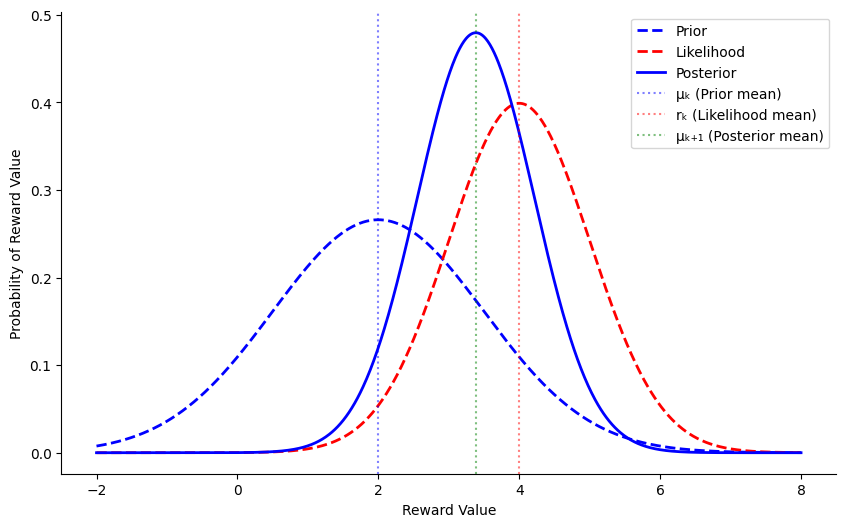

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
mu_k = 2.0  # Prior mean
r_k = 4.0   # Likelihood mean
prior_std = 1.5
likelihood_std = 1.0

# Calculate posterior parameters (using precision form)
posterior_std = 1 / np.sqrt(1/prior_std**2 + 1/likelihood_std**2)
posterior_mean = posterior_std**2 * (mu_k/prior_std**2 + r_k/likelihood_std**2)

# Create x values for plotting
x = np.linspace(-2, 8, 1000)

# Calculate distributions
prior = norm.pdf(x, mu_k, prior_std)
likelihood = norm.pdf(x, r_k, likelihood_std)
posterior = norm.pdf(x, posterior_mean, posterior_std)

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(x, prior, 'b--', label='Prior', linewidth=2)
plt.plot(x, likelihood, 'r--', label='Likelihood', linewidth=2)
plt.plot(x, posterior, 'b-', label='Posterior', linewidth=2)

# Add vertical lines for means
plt.axvline(x=mu_k, color='b', linestyle=':', alpha=0.5, label='μₖ (Prior mean)')
plt.axvline(x=r_k, color='r', linestyle=':', alpha=0.5, label='rₖ (Likelihood mean)')
plt.axvline(x=posterior_mean, color='g', linestyle=':', alpha=0.5, label='μₖ₊₁ (Posterior mean)')

# Customize plot
plt.xlabel('Reward Value')
plt.ylabel('Probability of Reward Value')
plt.legend()
#plt.grid(True, alpha=0.3)
# hide spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show plot
plt.show()